# Tuning Model

In [1]:
import model
import numpy as np
import pandas as pd
import tree
from sklearn.linear_model import LinearRegression

In [2]:
# Calculate Optimal M Value
x_file = 'synthetic_data/batch_1/x_gen_syn_n3_p10_corr0.5_snr5.0_seed2022_0.csv'
y_file = 'synthetic_data/batch_1/y_gen_syn_n3_p10_corr0.5_snr5.0_seed2022_0.csv'
x = np.loadtxt(x_file, delimiter=",")
y = np.loadtxt(y_file, delimiter=",")
l0 = 0.01
l2 = 0

# Fit a linear regression model to estimate coefficients (betas)
linear_model = LinearRegression()
linear_model.fit(x, y)

# Calculate the maximum absolute coefficient value
max_abs_beta = np.max(np.abs(linear_model.coef_))

# Calculate the optimal M value as 1.5 times the maximum absolute coefficient value
optimal_M = 1.5 * max_abs_beta

print(f"Optimal M: {optimal_M}")

Optimal M: 1.342228603310831


# Retro Branching

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

### Rough Visualization of Tree Structure

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=2., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5, pos = None, parent = None, parsed = []):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)  
            
    if len(children) != 0:
        dx = width / len(children) 
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    
    return pos

def visualize_tree(root):
    if not root:
        return

    tree_graph = nx.DiGraph()

    def add_nodes_edges(node):
        if node.left:
            tree_graph.add_edge(node.node_key, node.left.node_key)
            add_nodes_edges(node.left)
        if node.right:
            tree_graph.add_edge(node.node_key, node.right.node_key)
            add_nodes_edges(node.right)

    add_nodes_edges(root)

    pos = hierarchy_pos(tree_graph, root.node_key)
    nx.draw(tree_graph, pos=pos, with_labels=True, node_size=100, node_color="skyblue", font_size=6, font_weight='bold')
    plt.title("Binary Tree Visualization")
    plt.show()

In [4]:
# Solve using Branch and Bound
i, num_pos, test_tree = tree.branch_and_bound(x,y,l0,l2)

def count_nodes(node):
    """Count the number of nodes in the tree."""
    if not node:
        return 0
    return 1 + count_nodes(node.left) + count_nodes(node.right)

print(f'Number of Nodes in Tree: {count_nodes(test_tree.root)}')

Number of Nodes in Tree: 107


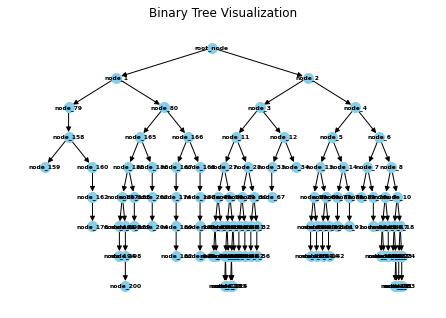

In [6]:
visualize_tree(test_tree.root)

In [7]:
pairs = tree.get_state_pairs(test_tree.root)
print(f'Number of Edges/State Pairs: {len(pairs)}')

Number of Edges/State Pairs: 106


In [8]:
# Solve Using RL Agent
agent = model.Agent()

iters, tot_reward, test_tree = model.RL_solve(agent, x, y, l0, l2)

print(f'Iterations: {iters}')
print(f'Total Reward: {tot_reward}')
print(f'Number of Nodes in Tree: {count_nodes(test_tree.root)}')

c:\Users\kamee\Documents\GitHub\var_selection\model.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  state = torch.tensor([T.get_state(node_key, support[i])], dtype=torch.float)


Iterations: 103
Total Reward: -38
Number of Nodes in Tree: 103


In [9]:
# Agent Begins Optimizing once len(Memory) > 128
print(f'Number of Items in Memory: {len(agent.memory.memory)}')

Number of Items in Memory: 102


In [25]:
# Test that Optimization of Model works
iters, tot_reward, test_tree = model.RL_solve(agent, x, y, l0, l2)

print(f'Iterations This Episode: {iters}')
print(f'Total Reward this Episode: {tot_reward}')
print(f'Number of Items in Memory: {len(agent.memory.memory)}')
print("-----------------------------------------")
print(f'Episodes Played: {agent.episodes_played}')

Iterations This Episode: 70
Total Reward this Episode: -26
Number of Items in Memory: 1231
-----------------------------------------
Episodes Played: 17
